# Resume Classification

In [ ]:
# Installing tika - a server which is written in JAVA for text extracting ( JAVA must be installed in the device)
#!pip install tika

In [ ]:
!pip install tika

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tika import parser

In [ ]:
# Importing all required packages
import os
import re
import string

import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score


import warnings
warnings.filterwarnings('ignore')

## Extracting Text

In [ ]:
# Function to parse the data from the file using tika package

def extract_text(file_path):
    parsed = parser.from_file(file_path)
    return parsed["content"]

In [ ]:
# listing the subfolders available inside the main folder
dataset_path = '/content/drive/MyDrive/Resumes_Docx'
folder_list = os.listdir(dataset_path)
folder_list

In [ ]:
# To save the extracted data and role in a list
raw_text = []

# Reading through the dataset and adding to the list
for role in folder_list:
    # Adding a '/' to the path to fix the file path issue
    for eachFile in os.listdir(os.path.join(dataset_path, role)):
        text = re.sub(r'^\n+', '', extract_text(os.path.join(dataset_path, role, eachFile)), count=1) # Extracting the text for the particular file
         # Creating a Dictionary containing 2 key&value pairs for dataframe creation
        new_row = {'job_role': role, 'text': text}
        raw_text.append(new_row)

In [ ]:
# Creating the DataFrame
resume_dataset = pd.DataFrame(data= raw_text, columns=['job_role', 'text'])
resume_dataset

,job_role,text
0,Peoplesoft Resume,PEOPLESOFT Administrator\nSRINIVAS.K \n\n\n\n\...
1,Peoplesoft Resume,Arun Venu\n EXPERIENCE SUMMARY\n\n· Experienc...
2,Peoplesoft Resume,PeopleSoft Database Administrator\n\nPeopleSof...
3,Peoplesoft Resume,Hari Narayana \t\t \n\n\n\tPROFES...
4,Peoplesoft Resume,PeopleSoft Administration\n \nVivekanand Sayan...
...,...,...
74,workday,Shireesh Balasani ...
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...
76,workday,HIMA.MENDU\nCareer Objective\n\nTo continue gr...
77,workday,Name:\nJ. Sumanth Royal.\nPROFESSIONAL SUMMARY...


In [ ]:
#Checking the raw data
print(resume_dataset['text'][4])

PeopleSoft Administration
 
Vivekanand Sayana                                                                                                                                                                                                           	

Career Objective: 

With my valid expertise of 7.5 years in PeopleSoft, I hope to enhance my skill set while adding value to the business, to enable implementation of solutions, which aid the company’s objectives, understanding and anticipating the needs, interests and motivations of the clients and to deliver on time, budget and to quality, delivering value through improving agility, quality and reliability

Professional Summary:

· Over 7.5 years of experience in PeopleSoft implementation, Support, configuration, migrations, maintenance and administration of Application Server Domains, Process Scheduler Servers, Web Server Domains, PeopleTools Upgrades, Application Updates, PUM, SES and Elastic Search. 
· Experience in integration activi

In [ ]:
# Replacing the value Peoplesoft Resume with Peoplesoft
resume_dataset['job_role'] = resume_dataset['job_role'].replace('Peoplesoft Resume', 'Peoplesoft', regex=True)
resume_dataset['job_role'].value_counts()

,count
job_role,
React Developer,24
workday,21
Peoplesoft,20
SQL Developer,14


In [ ]:
# Create a job_role count plot
fig = px.histogram(resume_dataset, x="job_role", color=resume_dataset['job_role'])

# Update the layout with labels and title
fig.update_layout(
    xaxis_title="Job Role",
    yaxis_title="No of Resumes",
    title="No of resumes according to Job Role"
)

fig.show()

## EDA

In [ ]:
# Function to remove Emojies
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [ ]:
# Function to clean the text of special and unwanted characters

def clean_text(text):
    cleaned_text = str(text)
    # Remove email-like addresses
    cleaned_text = re.sub(r'\S+@\S+', '', cleaned_text)
    # Remove links
    cleaned_text = re.sub(r'\S+\.com\S*', '', cleaned_text)
    # Remove URLS
    cleaned_text = re.sub(r'http\S+', '', cleaned_text)
    # Remove Emojis
    cleaned_text = deEmojify(cleaned_text)
    # Remove images
    cleaned_text = re.sub(r'\b\w+\.(png|jpg|jpeg)\b', '', text)
    # Removing the escape characters
    cleaned_text = re.sub(r'\\.', '', cleaned_text)
    # Removing bullets
    cleaned_text = re.sub(r' · ', '', cleaned_text)
    # Remove all the non-alpha symbols
    cleaned_text = re.sub(r'[^a-zA-Z]',' ',cleaned_text)
    # Replace multiple spaces with a single space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # Removing 2 character word
    cleaned_text = re.sub(r'\b([a-zA-Z])\1\b', "", cleaned_text)
    # Removing single character word
    cleaned_text = re.sub(r'\b[a-zA-Z]\b', "", cleaned_text)
    # Converting to the lowercase
    cleaned_text = cleaned_text.lower()

    return cleaned_text.strip()

In [ ]:
# Checking if the clean_text() function performs accurately
test_cleaning = clean_text(resume_dataset['text'][4])
print(test_cleaning)

peoplesoft administration vivekanand sayana career objective with my valid expertise of years in peoplesoft  hope to enhance my skill set while adding value to the business to enable implementation of solutions which aid the company  objectives understanding and anticipating the needs interests and motivations of the clients and to deliver on time budget and to quality delivering value through improving agility quality and reliability professional summary over years of experience in peoplesoft implementation support configuration migrations maintenance and administration of application server domains process scheduler servers web server domains peopletools upgrades application updates pum ses and elastic search experience in integration activities between various peoplesoft financials hrms epm and fscm environments extensively involved in resolving performance issues experience in driving infrastructure hardware upgrades disaster recovery activities experience in health check for all t

In [ ]:
# Applying clean_text() function to the Raw text and saving it to the new column
resume_dataset['Cleaned_data'] = resume_dataset['text'].apply(clean_text)
resume_dataset

,job_role,text,Cleaned_data
0,Peoplesoft,PEOPLESOFT Administrator\nSRINIVAS.K \n\n\n\n\...,peoplesoft administrator srinivas experience ...
1,Peoplesoft,Arun Venu\n EXPERIENCE SUMMARY\n\n· Experienc...,arun venu experience summary experience of yea...
2,Peoplesoft,PeopleSoft Database Administrator\n\nPeopleSof...,peoplesoft database administrator peoplesoft d...
3,Peoplesoft,Hari Narayana \t\t \n\n\n\tPROFES...,hari narayana professional summary having year...
4,Peoplesoft,PeopleSoft Administration\n \nVivekanand Sayan...,peoplesoft administration vivekanand sayana ca...
...,...,...,...
74,workday,Shireesh Balasani ...,shireesh balasani hcm consultant profile summa...
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...,srikanth workday hcm consultant seeking suitab...
76,workday,HIMA.MENDU\nCareer Objective\n\nTo continue gr...,hima mendu career objective to continue growin...
77,workday,Name:\nJ. Sumanth Royal.\nPROFESSIONAL SUMMARY...,name sumanth royal professional summary have ...


In [ ]:
# Count the number of words in tthe text

def count_words_basic(text):
    # Split the text into words using whitespace as delimiter
    words = text.split()
    return len(words)

In [ ]:
# Apply the count_words_basic function to the DataFrame
resume_dataset['No_of_words'] = resume_dataset['Cleaned_data'].apply(count_words_basic)
resume_dataset

,job_role,text,Cleaned_data,No_of_words
0,Peoplesoft,PEOPLESOFT Administrator\nSRINIVAS.K \n\n\n\n\...,peoplesoft administrator srinivas experience ...,2397
1,Peoplesoft,Arun Venu\n EXPERIENCE SUMMARY\n\n· Experienc...,arun venu experience summary experience of yea...,981
2,Peoplesoft,PeopleSoft Database Administrator\n\nPeopleSof...,peoplesoft database administrator peoplesoft d...,767
3,Peoplesoft,Hari Narayana \t\t \n\n\n\tPROFES...,hari narayana professional summary having year...,444
4,Peoplesoft,PeopleSoft Administration\n \nVivekanand Sayan...,peoplesoft administration vivekanand sayana ca...,1979
...,...,...,...,...
74,workday,Shireesh Balasani ...,shireesh balasani hcm consultant profile summa...,1456
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...,srikanth workday hcm consultant seeking suitab...,874
76,workday,HIMA.MENDU\nCareer Objective\n\nTo continue gr...,hima mendu career objective to continue growin...,461
77,workday,Name:\nJ. Sumanth Royal.\nPROFESSIONAL SUMMARY...,name sumanth royal professional summary have ...,792


In [ ]:
# Load the SpaCy language model
nlp = spacy.load("en_core_web_sm")

# Function to do text normalization
def lemmatization(text):
    # Process the text
    doc = nlp(text)
    # Extract and lemmatize tokens
    lemmatized_tokens = [token.lemma_.strip() for token in doc]
    return ' '.join(lemmatized_tokens)

In [ ]:
# Apply the lemmatization function to the DataFrame
resume_dataset['Cleaned_data'] = resume_dataset['Cleaned_data'].apply(lemmatization)

# Apply the count_words_basic function to the DataFrame
resume_dataset['No_of_words'] = resume_dataset['Cleaned_data'].apply(count_words_basic)
resume_dataset

,job_role,text,Cleaned_data,No_of_words
0,Peoplesoft,PEOPLESOFT Administrator\nSRINIVAS.K \n\n\n\n\...,peoplesoft administrator srinivas experience ...,2397
1,Peoplesoft,Arun Venu\n EXPERIENCE SUMMARY\n\n· Experienc...,arun venu experience summary experience of yea...,981
2,Peoplesoft,PeopleSoft Database Administrator\n\nPeopleSof...,peoplesoft database administrator peoplesoft d...,767
3,Peoplesoft,Hari Narayana \t\t \n\n\n\tPROFES...,hari narayana professional summary have year o...,444
4,Peoplesoft,PeopleSoft Administration\n \nVivekanand Sayan...,peoplesoft administration vivekanand sayana ca...,1979
...,...,...,...,...
74,workday,Shireesh Balasani ...,shireesh balasani hcm consultant profile summa...,1456
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...,srikanth workday hcm consultant seek suitable ...,874
76,workday,HIMA.MENDU\nCareer Objective\n\nTo continue gr...,hima mendu career objective to continue grow i...,461
77,workday,Name:\nJ. Sumanth Royal.\nPROFESSIONAL SUMMARY...,name sumanth royal professional summary have ...,792


In [ ]:
# download additional data resources for nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Function removes stopwords from the text
def remove_stopwords(text):
    # Define stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text) # Tokenize the text
    filtered_text = [word.strip() for word in word_tokens if word.lower() not in stop_words] # Filter out stopwords

    return ' '.join(filtered_text)

In [ ]:
!pip install nltk
import nltk

# Download the required resources
nltk.download('punkt_tab')
nltk.download('stopwords')

# ... your existing code ...

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Apply the remove_stopwords function to the DataFrame
resume_dataset['Cleaned_data'] = resume_dataset['Cleaned_data'].apply(remove_stopwords)
resume_dataset

# Apply the count_words_basic function to the DataFrame
resume_dataset['No_of_words'] = resume_dataset['Cleaned_data'].apply(count_words_basic)
resume_dataset

,job_role,text,Cleaned_data,No_of_words
0,Peoplesoft,PEOPLESOFT Administrator\nSRINIVAS.K \n\n\n\n\...,peoplesoft administrator srinivas experience s...,1751
1,Peoplesoft,Arun Venu\n EXPERIENCE SUMMARY\n\n· Experienc...,arun venu experience summary experience year m...,788
2,Peoplesoft,PeopleSoft Database Administrator\n\nPeopleSof...,peoplesoft database administrator peoplesoft d...,589
3,Peoplesoft,Hari Narayana \t\t \n\n\n\tPROFES...,hari narayana professional summary year experi...,354
4,Peoplesoft,PeopleSoft Administration\n \nVivekanand Sayan...,peoplesoft administration vivekanand sayana ca...,1466
...,...,...,...,...
74,workday,Shireesh Balasani ...,shireesh balasani hcm consultant profile summa...,1083
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...,srikanth workday hcm consultant seek suitable ...,668
76,workday,HIMA.MENDU\nCareer Objective\n\nTo continue gr...,hima mendu career objective continue grow know...,354
77,workday,Name:\nJ. Sumanth Royal.\nPROFESSIONAL SUMMARY...,name sumanth royal professional summary total ...,604


In [ ]:
# Removing the follwing NER from the dataset

ner_categories =  ['PERSON','GPE','LOC','NORP', 'FAC','PRODUCT','EVENT','WORK_OF_ART','DATE','TIME','LANGUAGE','MONEY']   # https://dataknowsall.com/blog/ner.html
def remove_NER_categories(text):
    doc = nlp(text)
    # Identify named entities and remove names
    cleaned_text = " ".join([token.text for token in doc if not token.ent_type_ in ner_categories])
    return cleaned_text

In [ ]:
# Apply the remove_names function to the DataFrame
resume_dataset['Cleaned_data'] = resume_dataset['Cleaned_data'].apply(remove_NER_categories)
resume_dataset

# Apply the count_words_basic function to the DataFrame
resume_dataset['No_of_words'] = resume_dataset['Cleaned_data'].apply(count_words_basic)
resume_dataset

,job_role,text,Cleaned_data,No_of_words
0,Peoplesoft,PEOPLESOFT Administrator\nSRINIVAS.K \n\n\n\n\...,peoplesoft administrator srinivas experience e...,1708
1,Peoplesoft,Arun Venu\n EXPERIENCE SUMMARY\n\n· Experienc...,arun venu experience summary experience multip...,762
2,Peoplesoft,PeopleSoft Database Administrator\n\nPeopleSof...,peoplesoft database administrator peoplesoft d...,576
3,Peoplesoft,Hari Narayana \t\t \n\n\n\tPROFES...,hari narayana professional summary year experi...,348
4,Peoplesoft,PeopleSoft Administration\n \nVivekanand Sayan...,peoplesoft administration vivekanand sayana ca...,1402
...,...,...,...,...
74,workday,Shireesh Balasani ...,hcm consultant profile summary hcm tester cons...,1039
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...,srikanth workday hcm consultant seek suitable ...,639
76,workday,HIMA.MENDU\nCareer Objective\n\nTo continue gr...,mendu career objective continue grow knowledge...,339
77,workday,Name:\nJ. Sumanth Royal.\nPROFESSIONAL SUMMARY...,name royal professional summary total year exp...,581


In [ ]:
# function to Use regular expressions to find and remove words with less than 3 characters

def remove_short_words(text):

    cleaned_text = re.sub(r'\b\w{1,2}\b', '', text)

    # Remove any extra spaces created by the removal
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text


In [ ]:
# Apply the remove_short_words function to the DataFrame
#resume_dataset['Cleaned_data'] = resume_dataset['Cleaned_data'].apply(remove_short_words)
#resume_dataset

# Apply the count_words_basic function to the DataFrame
#resume_dataset['No_of_words'] = resume_dataset['Cleaned_data'].apply(count_words_basic)
#resume_dataset

In [ ]:
# Combine all words into a single list
complete_text = " ".join(text for text in resume_dataset.Cleaned_data)
all_words = complete_text.split(" ")

# Count Word Frequencies
word_freq = Counter(all_words)

# Convert to DataFrame for plotting
word_counts_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)


# Step 5: Create the Plot
fig = px.bar(word_counts_df[0:20], x='Word', y='Frequency', title='Word Frequency Count on entire dataset',
             labels={'Word': 'Word', 'Frequency': 'Frequency'},
             color='Frequency', color_continuous_scale='Viridis')

# Show the plot
fig.show()


In [ ]:
# Plotting the word frequency according to the jon role

for each_role in resume_dataset['job_role'].unique().tolist():
    complete_text = " ".join(text for text in resume_dataset.Cleaned_data[resume_dataset['job_role'] == each_role])
    all_words = complete_text.split(" ")
    word_freq = Counter(all_words)
    word_counts_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    fig = px.bar(word_counts_df[0:20], x='Word', y='Frequency', title='Word Frequency Count on ' + each_role,
                labels={'Word': 'Word', 'Frequency': 'Frequency'},
                color='Frequency', color_continuous_scale='Viridis')
    fig.show()

In [ ]:
# Combine all words into a single list
complete_text = " ".join(text for text in resume_dataset.Cleaned_data)

# Generate the word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(complete_text)

# Convert the word cloud to a NumPy array
wordcloud_image = wordcloud.to_array()

# Display the word cloud using Plotly
fig = px.imshow(wordcloud_image)
fig.update_layout(title="Word Cloud",
                  xaxis=dict(showgrid=False, showticklabels=False),
                  yaxis=dict(showgrid=False, showticklabels=False))

# Increase the size of the
fig.update_layout(width=1200, height=600)

# Show the plot
fig.show()


In [ ]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(resume_dataset['Cleaned_data'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['job_role'] = resume_dataset['job_role']
# Display the TF-IDF features
tfidf_df

,abdul,ability,able,abreast,abs,absence,absent,abstract,abstraction,academic,...,yogi,yonder,young,yrs,zenefit,zero,zerozilla,zone,zp,job_role
0,0.0,0.044652,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,Peoplesoft
1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,Peoplesoft
2,0.0,0.000000,0.0,0.070853,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,Peoplesoft
3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,Peoplesoft
4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,Peoplesoft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.0,0.020987,0.0,0.000000,0.000000,0.066586,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.107766,0.0,0.0,0.0,0.0,workday
75,0.0,0.029512,0.0,0.000000,0.000000,0.131441,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,workday
76,0.0,0.036485,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,workday
77,0.0,0.030729,0.0,0.000000,0.075189,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,workday


In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Perform label encoding on the 'Fruit' column
tfidf_df['job_role'] = label_encoder.fit_transform(tfidf_df['job_role'] )

tfidf_df


,abdul,ability,able,abreast,abs,absence,absent,abstract,abstraction,academic,...,yogi,yonder,young,yrs,zenefit,zero,zerozilla,zone,zp,job_role
0,0.0,0.044652,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
2,0.0,0.000000,0.0,0.070853,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.0,0.020987,0.0,0.000000,0.000000,0.066586,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.107766,0.0,0.0,0.0,0.0,3
75,0.0,0.029512,0.0,0.000000,0.000000,0.131441,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3
76,0.0,0.036485,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3
77,0.0,0.030729,0.0,0.000000,0.075189,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3


In [ ]:
# Display the mapping of labels
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print("Label Mapping:", label_mapping)

Label Mapping: {0: 'Peoplesoft', 1: 'React Developer', 2: 'SQL Developer', 3: 'workday'}


In [ ]:
print(tfidf_df.columns.tolist())

['abdul', 'ability', 'able', 'abreast', 'abs', 'absence', 'absent', 'abstract', 'abstraction', 'academic', 'accenture', 'accept', 'acceptable', 'acceptance', 'access', 'accessibility', 'accessible', 'accessory', 'acclimatize', 'accommodate', 'accomplish', 'accomplished', 'accord', 'account', 'accountant', 'accounting', 'accuracy', 'achieve', 'achievement', 'acknowledge', 'acknowledgement', 'acquaint', 'acquire', 'acquisition', 'acs', 'act', 'action', 'actionable', 'activate', 'active', 'actively', 'activity', 'ad', 'adapt', 'adaptability', 'adaptive', 'add', 'additional', 'additionally', 'additive', 'addm', 'address', 'adept', 'adhere', 'adhoc', 'aditya', 'admin', 'adminission', 'administer', 'administrate', 'administration', 'administrative', 'administrator', 'admission', 'ado', 'adobe', 'adopt', 'adp', 'adult', 'advance', 'advanced', 'advancement', 'advantage', 'advice', 'ae', 'aeroplane', 'aetna', 'affect', 'affigent', 'affiliate', 'affirm', 'aforementione', 'ag', 'age', 'agent', 'a

In [ ]:
# Copied the tfidf_df
final_df = tfidf_df.copy()

# Model Building

#### List of the models :

 - Random Forest

 - Naive Bayes

 - KNN

 - Decision Tree

 - SVM

 - XGBoost

 - Logistic Regression

In [ ]:
#Create a function to plot heatmap for confusion_matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    fig = px.imshow(cm,
                     x=['Peoplesoft','React Developer','SQL Developer','workday'],
                     y=['Peoplesoft','React Developer','SQL Developer','workday'],
                     text_auto=True, aspect="auto",
                     labels=dict(x="Predicted value", y="Actual value"), title = 'Confusion Matrix'
                    )
    fig.show()

In [ ]:
# Looking into the final_df
final_df

,abdul,ability,able,abreast,abs,absence,absent,abstract,abstraction,academic,...,yogi,yonder,young,yrs,zenefit,zero,zerozilla,zone,zp,job_role
0,0.0,0.044652,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
2,0.0,0.000000,0.0,0.070853,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.0,0.020987,0.0,0.000000,0.000000,0.066586,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.107766,0.0,0.0,0.0,0.0,3
75,0.0,0.029512,0.0,0.000000,0.000000,0.131441,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3
76,0.0,0.036485,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3
77,0.0,0.030729,0.0,0.000000,0.075189,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3


In [ ]:
# Divides the dataset to X and y
X = final_df.iloc[:,0:-1]
y = final_df['job_role']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Random Forest

In [ ]:
# Create the Random Forest classifier
rf_clf = RandomForestClassifier()

# Train the classifier
rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_clf.predict(X_test)

In [ ]:

print("Accuracy train: ", accuracy_score(y_train, rf_clf.predict(X_train)))
print("Accuracy test: ", accuracy_score(y_test, y_pred_rf))

Accuracy train:  1.0
Accuracy test:  0.9583333333333334


In [ ]:
# Confusion matrix for test data
plot_confusion_matrix(y_test, y_pred_rf)

In [ ]:
# Classification report on the test dataset
print(classification_report(y_test, y_pred_rf, target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         7
React Developer       0.86      1.00      0.92         6
  SQL Developer       1.00      0.80      0.89         5
        workday       1.00      1.00      1.00         6

       accuracy                           0.96        24
      macro avg       0.96      0.95      0.95        24
   weighted avg       0.96      0.96      0.96        24



In [ ]:
# Adding the evaluation metrics to the variable
precision_rf = round(precision_score(y_test,y_pred_rf,average = 'macro'),2)
recall_rf = round(recall_score(y_test,y_pred_rf, average = 'macro'),2)
f1_rf = round(f1_score(y_test,y_pred_rf, average = 'macro'),2)
accuracy_test_rf = round(accuracy_score(y_test,y_pred_rf),2)
accuracy_train_rf =rf_clf.score(X_train, y_train)

### Naive Bayes

In [ ]:
#Initialize the Multionomial Naive Bayes model
nb_model=MultinomialNB()

# Train the classifier
nb_model.fit(X_train,y_train)

# Make predictions on the test set
nbm_predictions=nb_model.predict(X_test)

In [ ]:
# Evaluate the model
print("Accuracy train: ", accuracy_score(y_train, nb_model.predict(X_train)))
print("Accuracy test: ", accuracy_score(y_test, nbm_predictions))

Accuracy train:  1.0
Accuracy test:  0.8333333333333334


In [ ]:
# Confusion matrix for test data
plot_confusion_matrix(y_test, nbm_predictions)

In [ ]:
# Classification report on the test dataset
print(classification_report(y_test, nbm_predictions, target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      0.86      0.92         7
React Developer       0.75      1.00      0.86         6
  SQL Developer       1.00      0.40      0.57         5
        workday       0.75      1.00      0.86         6

       accuracy                           0.83        24
      macro avg       0.88      0.81      0.80        24
   weighted avg       0.88      0.83      0.82        24



In [ ]:
# Adding the evaluation metrics to the variable
precision_nb = round(precision_score(y_test,nbm_predictions,average = 'macro'),2)
recall_nb = round(recall_score(y_test,nbm_predictions, average = 'macro'),2)
f1_nb = round(f1_score(y_test,nbm_predictions, average = 'macro'),2)
accuracy_test_nb = round(accuracy_score(y_test,nbm_predictions),2)
accuracy_train_nb =nb_model.score(X_train, y_train)

### KNN

In [ ]:
#Finding the optimal value of ‘K’
train_score={}
test_score={}
n_neighbors=np.arange(2,31,1)
for i in n_neighbors:
  knn=KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train,y_train)
  train_score[i]=knn.score(X_train,y_train)
  test_score[i]=knn.score(X_test,y_test)

In [ ]:
# PLotting K v/s accuracy graph
train = go.Scatter(x=list(n_neighbors), y=list(train_score.values()), mode='lines', name='Train Accuracy')
test= go.Scatter(x=list(n_neighbors), y=list(test_score.values()), mode='lines', name='Test Accuracy')
fig = go.Figure(data=[train, test])

fig.update_layout(title='KNN: Varying number of Neighbors',
                  xaxis_title='Number Of Neighbors',
                  yaxis_title='Accuracy')

fig.show()

Text(0, 0.5, 'Error Rate')

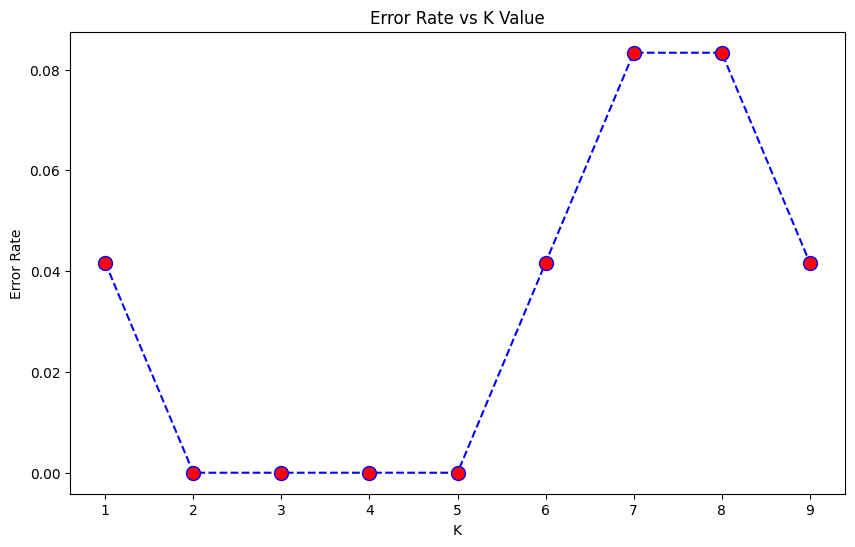

In [ ]:
# PLotting K v/s error rate
error_rate=[]
for i in range(1,10):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i=knn.predict(X_test)
    error_rate.append(np.mean(pred_i!=y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
# Training KNN classifier
knn=KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)

#Predicting the The Test Data with model
y_pred_knn=knn.predict(X_test)

In [ ]:
# accuracy on train and test balance data
print("The KNN Model accuracy on train data - ", knn.score(X_train, y_train))
print("The KNN Model accuracy on test data - ", knn.score(X_test, y_test))

The KNN Model accuracy on train data -  0.6909090909090909
The KNN Model accuracy on test data -  0.5416666666666666


In [ ]:
#Confusion Matrix for test Data
plot_confusion_matrix(y_test,y_pred_knn)

In [ ]:
# Classification report on the test dataset
print(classification_report(y_test, y_pred_knn, target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         7
React Developer       1.00      1.00      1.00         6
  SQL Developer       1.00      1.00      1.00         5
        workday       1.00      1.00      1.00         6

       accuracy                           1.00        24
      macro avg       1.00      1.00      1.00        24
   weighted avg       1.00      1.00      1.00        24



In [ ]:
# Adding the evaluation metrics to the variable
precision_knn = round(precision_score(y_test,y_pred_knn,average = 'macro'),2)
recall_knn = round(recall_score(y_test,y_pred_knn, average = 'macro'),2)
f1_knn = round(f1_score(y_test,y_pred_knn, average = 'macro'),2)
accuracy_test_knn = round(accuracy_score(y_test,y_pred_knn),2)
accuracy_train_knn =knn.score(X_train, y_train)

### Decision tree

In [ ]:
#Initialize and train the DecisionTreeClassifier model
DT_model=DecisionTreeClassifier(random_state=42, max_depth=4)
DT_model.fit(X_train,y_train)

#Predicting the The Test Data with model
DT_model_pred=DT_model.predict(X_test)

In [ ]:
# checking accuracy on Train & test data
print("The Decision Tree Model accuracy on train data - ", DT_model.score(X_train,y_train))
print("The Decision Tree Model accuracy on test data - ", DT_model.score(X_test,y_test))

The Decision Tree Model accuracy on train data -  1.0
The Decision Tree Model accuracy on test data -  0.7916666666666666


In [ ]:
# Confusion matrix for test data
plot_confusion_matrix(y_test,DT_model_pred)

In [ ]:
# Classification Report for test Data
print(classification_report(y_test,DT_model_pred,target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       0.67      0.86      0.75         7
React Developer       0.83      0.83      0.83         6
  SQL Developer       0.75      0.60      0.67         5
        workday       1.00      0.83      0.91         6

       accuracy                           0.79        24
      macro avg       0.81      0.78      0.79        24
   weighted avg       0.81      0.79      0.79        24



In [ ]:
# Adding the evaluation metrics to the variable
precision_dt = round(precision_score(y_test,DT_model_pred,average = 'macro'),2)
recall_dt = round(recall_score(y_test,DT_model_pred, average = 'macro'),2)
f1_dt = round(f1_score(y_test,DT_model_pred, average = 'macro'),2)
accuracy_test_dt = round(accuracy_score(y_test,DT_model_pred),2)
accuracy_train_dt =DT_model.score(X_train, y_train)

### SVM

In [ ]:
# Create the SVM classifier
svc_model = SVC()

# Train the classifier
svc_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svc_model.predict(X_test)

In [ ]:
# checking accuracy on Train & test data
print("The SVM Model accuracy on train data - ", svc_model.score(X_train,y_train))
print("The SVM Model accuracy on test data - ", svc_model.score(X_test,y_test))

The SVM Model accuracy on train data -  1.0
The SVM Model accuracy on test data -  0.9166666666666666


In [ ]:
# Confusion matrix for test data
plot_confusion_matrix(y_test,y_pred_svm)

In [ ]:
# Classification Report for test Data
print(classification_report(y_test,y_pred_svm,target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         7
React Developer       0.75      1.00      0.86         6
  SQL Developer       1.00      0.60      0.75         5
        workday       1.00      1.00      1.00         6

       accuracy                           0.92        24
      macro avg       0.94      0.90      0.90        24
   weighted avg       0.94      0.92      0.91        24



In [ ]:
# Adding the evaluation metrics to the variable
precision_svm = round(precision_score(y_test,y_pred_svm,average = 'macro'),2)
recall_svm = round(recall_score(y_test,y_pred_svm, average = 'macro'),2)
f1_svm = round(f1_score(y_test,y_pred_svm, average = 'macro'),2)
accuracy_test_svm = round(accuracy_score(y_test,y_pred_svm),2)
accuracy_train_svm =svc_model.score(X_train, y_train)

### XGBoost Classifier

In [ ]:
# Create the XGBoost classifier
xg_boost_model = XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3)

# Train the classifier
xg_boost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgc = xg_boost_model.predict(X_test)

In [ ]:
# checking accuracy on Train & test data
print("The XGBoost Model accuracy on train data - ", xg_boost_model.score(X_train,y_train))
print("The XGBoost Model accuracy on test data - ", xg_boost_model.score(X_test,y_test))

The XGBoost Model accuracy on train data -  1.0
The XGBoost Model accuracy on test data -  1.0


In [ ]:
# Confusion matrix for test data
plot_confusion_matrix(y_test,y_pred_xgc)

In [ ]:
# Classification Report for test Data
print(classification_report(y_test,y_pred_xgc,target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         7
React Developer       1.00      1.00      1.00         6
  SQL Developer       1.00      1.00      1.00         5
        workday       1.00      1.00      1.00         6

       accuracy                           1.00        24
      macro avg       1.00      1.00      1.00        24
   weighted avg       1.00      1.00      1.00        24



In [ ]:
# Adding the evaluation metrics to the variable
precision_xgc = round(precision_score(y_test,y_pred_xgc,average = 'macro'),2)
recall_xgc = round(recall_score(y_test,y_pred_xgc, average = 'macro'),2)
f1_xgc = round(f1_score(y_test,y_pred_xgc, average = 'macro'),2)
accuracy_test_xgc = round(accuracy_score(y_test,y_pred_xgc),2)
accuracy_train_xgc =xg_boost_model.score(X_train, y_train)

## Logistic Regression

In [ ]:
# Initialize Logistic Regression with One-vs-Rest strategy
logistic_model = OneVsRestClassifier(LogisticRegression(max_iter=500, random_state=42))

# Fit the model to the training data
logistic_model.fit(X_train, y_train)

# Predict on the test set
y_pred = logistic_model.predict(X_test)

In [ ]:
# checking accuracy on Train & test data
print("The Logistic Regression Model accuracy on train data - ", logistic_model.score(X_train,y_train))
print("The Logistic Regression accuracy on test data - ", logistic_model.score(X_test,y_test))

The Logistic Regression Model accuracy on train data -  1.0
The Logistic Regression accuracy on test data -  0.875


In [ ]:
# Confusion matrix for test data
plot_confusion_matrix(y_test,y_pred)

In [ ]:
# Classification Report for test Data
print(classification_report(y_test,y_pred,target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         7
React Developer       0.67      1.00      0.80         6
  SQL Developer       1.00      0.40      0.57         5
        workday       1.00      1.00      1.00         6

       accuracy                           0.88        24
      macro avg       0.92      0.85      0.84        24
   weighted avg       0.92      0.88      0.86        24



In [ ]:
# Adding the evaluation metrics to the variable
precision_LRM = round(precision_score(y_test,y_pred,average = 'macro'),2)
recall_LRM = round(recall_score(y_test,y_pred, average = 'macro'),2)
f1_LRM = round(f1_score(y_test,y_pred, average = 'macro'),2)
accuracy_test_LRM = round(accuracy_score(y_test,y_pred),2)
accuracy_train_LRM =logistic_model.score(X_train, y_train)

### Model Evaluation

In [ ]:
evaluation = {"Models":["KNN Classifier","DecisionTree Classifier","RandomForest Classifier","SVM Classifier",
                        "XGBoost Classifier","Naive Bayes Classifier","Logistic Regression"],\
            "Train_Accuracy":[accuracy_train_knn,accuracy_train_dt,accuracy_train_rf,accuracy_train_svm,accuracy_train_xgc,accuracy_train_nb,accuracy_train_LRM],
            "Test_Accuracy":[accuracy_test_knn,accuracy_test_dt,accuracy_test_rf,accuracy_test_svm,accuracy_test_xgc,accuracy_test_nb,accuracy_test_LRM],\
            "Precision":[precision_knn,precision_dt,precision_rf,precision_svm,precision_xgc,precision_nb,precision_LRM],\
            "Recall":[recall_knn,recall_dt,recall_rf,recall_svm,recall_xgc,recall_nb,recall_LRM],\
            "F1-Score":[f1_knn,f1_dt,f1_rf,f1_svm,f1_xgc,f1_nb,f1_LRM]}
evaluation = pd.DataFrame(evaluation)
evaluation

,Models,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score
0,KNN Classifier,0.690909,1.00,1.00,1.00,1.00
1,DecisionTree Classifier,1.000000,0.79,0.81,0.78,0.79
2,RandomForest Classifier,1.000000,0.96,0.96,0.95,0.95
3,SVM Classifier,1.000000,0.92,0.94,0.90,0.90
4,XGBoost Classifier,1.000000,1.00,1.00,1.00,1.00
5,Naive Bayes Classifier,1.000000,0.83,0.88,0.81,0.80
6,Logistic Regression,1.000000,0.88,0.92,0.85,0.84


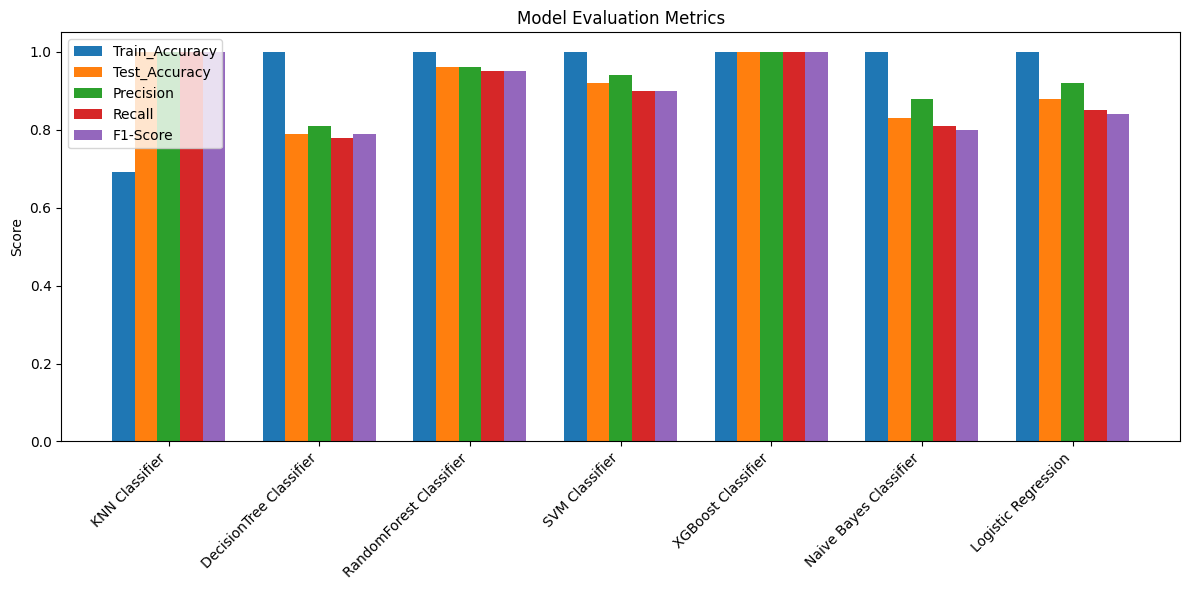

In [ ]:
# Setting the figure size
plt.figure(figsize=(12,6))

# Plotting each metric
metrics = ["Train_Accuracy", "Test_Accuracy", "Precision", "Recall", "F1-Score"]
x = range(len(evaluation["Models"]))

for i, metric in enumerate(metrics):
    # Calculate the bar positions
    bar_positions = [p + i * 0.15 for p in x]

    # Create the bars without adding the text labels
    bars = plt.bar(bar_positions, evaluation[metric], width=0.15, label=metric)

# Configure plot
plt.xticks([p + 0.3 for p in x], evaluation["Models"], rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Model Evaluation Metrics")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

***Out of all 7 models, we have got 4 models with best Accuracy score i.e, 1.00 are as follows :***

 **- KNN**

 **- DECISION TREE**

 **- RANDOM FOREST**

 **- XGBOOST**
